Max weight: 0.3665749728679657
Min weight: -1.3241188526153564


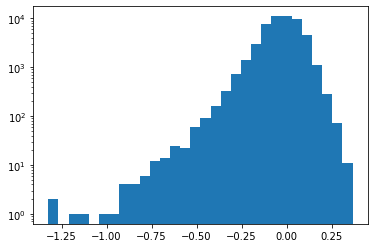

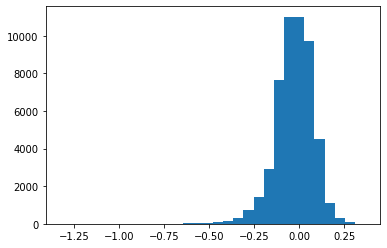

Max bias: 0.16357854008674622
Min bias: -0.23974871635437012
Max input: 1.0
Min input: 0.0


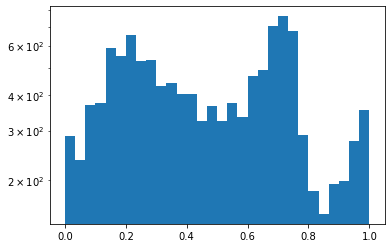

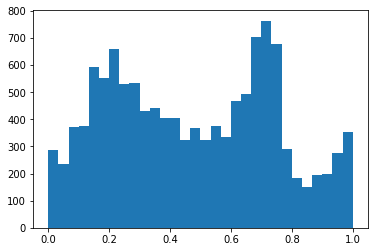

In [14]:
import glob
import matplotlib.pyplot as plt
import numpy as np

weights = []

for filename in glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/model/*weights.bin'):
    f = open(filename, mode="rb")

    weights = np.fromfile(f, dtype=np.float32)
    f.close()

print("Max weight: {0}".format(max(weights)))
print("Min weight: {0}".format(min(weights)))
plt.hist(weights, bins=30, log=True)
plt.show()
plt.hist(weights, bins=30)
plt.show()

biases = []

for filename in glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/model/*biases.bin'):
    f = open(filename, mode="rb")

    biases = np.fromfile(f, dtype=np.float32)
    f.close()

print("Max bias: {0}".format(max(biases)))
print("Min bias: {0}".format(min(biases)))

inputs = []

for filename in glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/*image_*.bin'):
    f = open(filename, mode="rb")

    inputs = np.fromfile(f, dtype=np.float32)
    f.close()

print("Max input: {0}".format(max(inputs)))
print("Min input: {0}".format(min(inputs)))

plt.hist(inputs, bins=30, log=True)
plt.show()
plt.hist(inputs, bins=30)
plt.show()

In [15]:
# from tiny_imagenet import TinyImagenetDataset

# tiny_imagenet_builder = TinyImagenetDataset()
# tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# ds = tiny_imagenet_builder.as_dataset()["train"]
# ds = ds.shuffle(1024)

# activations = []

# for image in ds.take(1000):
#     for act in image['image'].numpy().flatten():
#         #print(act)
#         activations.append(act)

# print("Max activation: {0}".format(max(activations)))
# print("Min activation: {0}".format(min(activations)))

# plt.hist(activations, bins=10)
# plt.show()

In [21]:
import os

ABSMAX_WEIGHT = 1.3241188526153564
ABSMAX_BIAS = 0.23974871635437012
ABSMAX_INPUT = 1.0
uint8_max = 127
int8_max = 255
int32_max = 2147483647

def quantize(input, scale):
    return int(scale * input)

def dequantize(input, scale):
    return float(input / scale)

def quantizeArray(input, scale):
    array = np.zeros(np.size(input))
    for index, element in enumerate(input):
        array[index] = quantize(element, scale)
    
    return array

def dequantizeArray(input, scale):
    array = np.zeros(np.size(input))
    for index, element in enumerate(input):
        array[index] = dequantize(element, scale)

    return array

In [17]:
for filename in glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/model/*weights.bin'):
    f = open(filename, mode="rb")

    weights = np.fromfile(f, dtype=np.float32)
    weights = quantizeArray(weights, int8_max / ABSMAX_WEIGHT)
    weights.astype('int8').tofile('../../lab2/cpre487-587-dnn-framework-main/data/quantized-model/{0}'.format(os.path.basename(filename)))
    f.close()

In [18]:

for filename in glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/model/*biases.bin'):
    f = open(filename, mode="rb")

    biases = np.fromfile(f, dtype=np.float32)
    biases = quantizeArray(biases, int32_max / ABSMAX_BIAS)
    biases.astype('int32').tofile('../../lab2/cpre487-587-dnn-framework-main/data/quantized-model/{0}'.format(os.path.basename(filename)))
    f.close()

In [19]:

for index, filename in enumerate(glob.glob('../../lab2/cpre487-587-dnn-framework-main/data/image*.bin')):
    f = open(filename, mode="rb")

    inputs = np.fromfile(f, dtype=np.float32)
    inputs = quantizeArray(inputs, uint8_max / ABSMAX_INPUT)
    inputs.astype('uint8').tofile('../../lab2/cpre487-587-dnn-framework-main/data/quantized_{0}'.format(os.path.basename(filename)))
    f.close()

## Comparison

In [26]:
f_original = open('../../lab2/cpre487-587-dnn-framework-main/data/model/conv1_weights.bin')
f_quantized = open('../../lab2/cpre487-587-dnn-framework-main/data/quantized-model/conv1_weights.bin')
original = np.fromfile(f_original, dtype=np.float32)
quantized = np.fromfile(f_quantized, dtype=np.int8)
dequantized = dequantizeArray(quantized, int8_max / ABSMAX_WEIGHT)
f_original.close()
f_quantized.close()

for i in range(0, 10):
    print('{4}:\n\toriginal: {0}\n\tquantized: {1}\n\tdequantized: {2}\n\t% error: {3}%\n'
          .format(original[i], quantized[i], dequantized[i], (original[i] - dequantized[i]) / dequantized[i] * 100, i + 1))

1:
	original: -0.021224262192845345
	quantized: -4
	dequantized: -0.02077049180573108
	% error: 2.1846877356512917%

2:
	original: 0.007459769491106272
	quantized: 1
	dequantized: 0.00519262295143277
	% error: 43.66091204538433%

3:
	original: 0.04947111755609512
	quantized: 9
	dequantized: 0.046733606562894936
	% error: 5.857692556888361%

4:
	original: 0.09378886222839355
	quantized: 18
	dequantized: 0.09346721312578987
	% error: 0.34413040877853235%

5:
	original: 0.08250445127487183
	quantized: 15
	dequantized: 0.07788934427149155
	% error: 5.925209727397155%

6:
	original: 0.03329572454094887
	quantized: 6
	dequantized: 0.03115573770859662
	% error: 6.868676493452992%

7:
	original: -0.02929776906967163
	quantized: -5
	dequantized: -0.02596311475716385
	% error: 12.843814556524533%

8:
	original: 0.07652157545089722
	quantized: 14
	dequantized: 0.07269672132005879
	% error: 5.261384642092595%

9:
	original: -0.05246942490339279
	quantized: -10
	dequantized: -0.0519262295143277
	% 

In [28]:
f_original = open('../../lab2/cpre487-587-dnn-framework-main/data/model/conv1_biases.bin')
f_quantized = open('../../lab2/cpre487-587-dnn-framework-main/data/quantized-model/conv1_biases.bin')
original = np.fromfile(f_original, dtype=np.float32)
quantized = np.fromfile(f_quantized, dtype=np.int32)
dequantized = dequantizeArray(quantized, int32_max / ABSMAX_BIAS)
f_original.close()
f_quantized.close()

for i in range(0, 10):
    print('{4}:\n\toriginal: {0}\n\tquantized: {1}\n\tdequantized: {2}\n\t% error: {3}%\n'
          .format(original[i], quantized[i], dequantized[i], (original[i] - dequantized[i]) / dequantized[i] * 100, i + 1))

1:
	original: 0.008284690789878368
	quantized: 74207855
	dequantized: 0.008284690784265247
	% error: 6.77529339985972e-08%

2:
	original: 0.007637986447662115
	quantized: 68415177
	dequantized: 0.007637986388311261
	% error: 7.770484401923541e-07%

3:
	original: -0.00736837787553668
	quantized: -66000232
	dequantized: -0.00736837783290958
	% error: 5.78514044755304e-07%

4:
	original: 0.030106404796242714
	quantized: 269669898
	dequantized: 0.03010640475667097
	% error: 1.3143962391403857e-07%

5:
	original: 0.0026063111145049334
	quantized: 23345319
	dequantized: 0.002606311005418933
	% error: 4.185455994648968e-06%

6:
	original: 0.05011480674147606
	quantized: 448889694
	dequantized: 0.05011480672812126
	% error: 2.6648404548049863e-08%

7:
	original: -0.028978634625673294
	quantized: -259568205
	dequantized: -0.028978634618286335
	% error: 2.549105296804719e-08%

8:
	original: 0.028560960665345192
	quantized: 255827004
	dequantized: 0.028560960593794132
	% error: 2.505204962579595e

In [31]:
f_original = open('../../lab2/cpre487-587-dnn-framework-main/data/image_0.bin')
f_quantized = open('../../lab2/cpre487-587-dnn-framework-main/data/quantized_image_0.bin')
original = np.fromfile(f_original, dtype=np.float32)
quantized = np.fromfile(f_quantized, dtype=np.uint8)
dequantized = dequantizeArray(quantized, uint8_max / ABSMAX_INPUT)
f_original.close()
f_quantized.close()

for i in range(0, 10):
    print('{4}:\n\toriginal: {0}\n\tquantized: {1}\n\tdequantized: {2}\n\t% error: {3}%\n'
          .format(original[i], quantized[i], dequantized[i], (original[i] - dequantized[i]) / dequantized[i] * 100, i + 1))

1:
	original: 0.14901961386203766
	quantized: 18
	dequantized: 0.14173228346456693
	% error: 5.14161644710435%

2:
	original: 0.1921568661928177
	quantized: 24
	dequantized: 0.1889763779527559
	% error: 1.683008360366028%

3:
	original: 0.2078431397676468
	quantized: 26
	dequantized: 0.2047244094488189
	% error: 1.5233798095813178%

4:
	original: 0.7215686440467834
	quantized: 91
	dequantized: 0.7165354330708661
	% error: 0.7024371361994554%

5:
	original: 0.7098039388656616
	quantized: 90
	dequantized: 0.7086614173228346
	% error: 0.16122248437670075%

6:
	original: 0.7450980544090271
	quantized: 94
	dequantized: 0.7401574803149606
	% error: 0.6675030956877015%

7:
	original: 0.7960784435272217
	quantized: 101
	dequantized: 0.7952755905511811
	% error: 0.1009527999575737%

8:
	original: 0.7019608020782471
	quantized: 89
	dequantized: 0.7007874015748031
	% error: 0.16744029655885498%

9:
	original: 0.7647058963775635
	quantized: 97
	dequantized: 0.7637795275590551
	% error: 0.121287463